In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
using KernelDensity
include("../../Inversion/Plot.jl")
include("../../Inversion/RWMCMC.jl")
include("../../Inversion/SMC.jl")
include("../../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

# Two Parameter Linear Inverse Problems

Consider the 2-parameter linear inverse problem
$$y = G\theta + \eta.$$
with $\eta \sim \mathcal{N}(0, 0.1^2I)$. We explore the following three scenarios

#### non-singular (well-determined) system (NS) 
   $$
   y = \begin{bmatrix}
        3 \\
        7 
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4
    \end{bmatrix} \quad
    \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix};
   $$ 
   
#### over-determined system (OD)
$$ y = \begin{bmatrix}
        3 \\
        7 \\
        10
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
        3 & 4 \\
        5 & 6
    \end{bmatrix} \quad
    \theta_{ref} = \begin{bmatrix}
        1/3 \\
        17/12
       \end{bmatrix};
$$ 
   
#### under-determined system (UD)
$$
y = \begin{bmatrix}
        3
       \end{bmatrix} \quad
       G = \begin{bmatrix}
        1 & 2\\
    \end{bmatrix} \quad
       \theta_{ref} = \begin{bmatrix}
        1 \\
        1 
       \end{bmatrix}
       + c\begin{bmatrix}
        2 \\
        -1 
       \end{bmatrix}, \,\,c \in \mathcal{R}.
$$
   
We define $$\displaystyle \theta_{ref} = argmin_{\theta}\frac{1}{2}\lVert\Sigma_{\eta}^{-\frac{1}{2}}(y - G\theta)\rVert^2,$$ and 
note that, in the UD case, $\theta_{ref}$ comprises a one-parameter family of possible solutions. We also note that $y = G\theta_{ref}$ for NS; and 
$y = G\theta_{ref}(c^\dagger)$ for UD, with $c^{\dagger}=0$; but for OD $y \ne  G\theta_{ref}.$ 

In [2]:
FT=Float64
mutable struct Setup_Param{MAT, IT<:Int}
    θ_names::Array{String,1}
    G::MAT
    N_θ::IT
    N_y::IT
end

function Setup_Param(G, N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], G, N_θ, N_y)
end


function forward(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    G = s_param.G 
    return G * θ
end

function forward_aug(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    G = s_param.G 
    return [G * θ; θ]
end


function compute_Φ(s_param::Setup_Param, θ::Array{FT, 1},  y::Array{FT, 1}, Σ_η::Array{FT, 2}, μ0::Array{FT, 1}, Σ0::Array{FT, 2}) 
    Φ   = 1/2*(y - G * θ)*(Σ_η\(y - G * θ)) + 1/2*(μ0 - θ)*(Σ0\(μ0 - θ))
    ∇Φ  = -G * (Σ_η\(y - G * θ)) - Σ0\(μ0 - θ)
    ∇²Φ = G * (Σ_η\G) + inv(Σ0)
    return Φ, ∇Φ, ∇²Φ
end

compute_Φ (generic function with 1 method)

In [3]:
function Two_Param_Linear_Test(problem_type::String, θ0_bar, θθ0_cov)
    
    N_θ = length(θ0_bar)

    
    if problem_type == "under-determined"
        # under-determined case
        θ_ref = [0.6, 1.2]
        G = [1.0 2.0;]
        
        y = [3.0;]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
        
    
    elseif problem_type == "over-determined"
        # over-determined case
        θ_ref = [1/3, 8.5/6]
        G = [1.0 2.0; 3.0 4.0; 5.0 6.0]
        
        y = [3.0;7.0;10.0]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
    elseif problem_type == "Hilbert"

        G = zeros(N_θ, N_θ)
        for i = 1:N_θ
            for j = 1:N_θ
                G[i,j] = 1/(i + j - 1)
            end
        end
    
        θ_ref = fill(1.0, N_θ)
        y   = G*θ_ref 
        Σ_η = Array(Diagonal(fill(0.5^2, N_θ)))
        
        
    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
    
    Σ_post = inv(G'*(Σ_η\G) + inv(θθ0_cov))
    θ_post = θ0_bar + Σ_post*(G'*(Σ_η\(y - G*θ0_bar)))
    

    return θ_post, Σ_post, G, y, Σ_η
end


function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    
    return x_cov/(N_ens - 1)
end

construct_cov (generic function with 11 methods)

┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-0.6457306721039767 -1.4632513788889214; -1.6236037455860806 -0.21766510678354617])
└ @ Main In[4]:38
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82


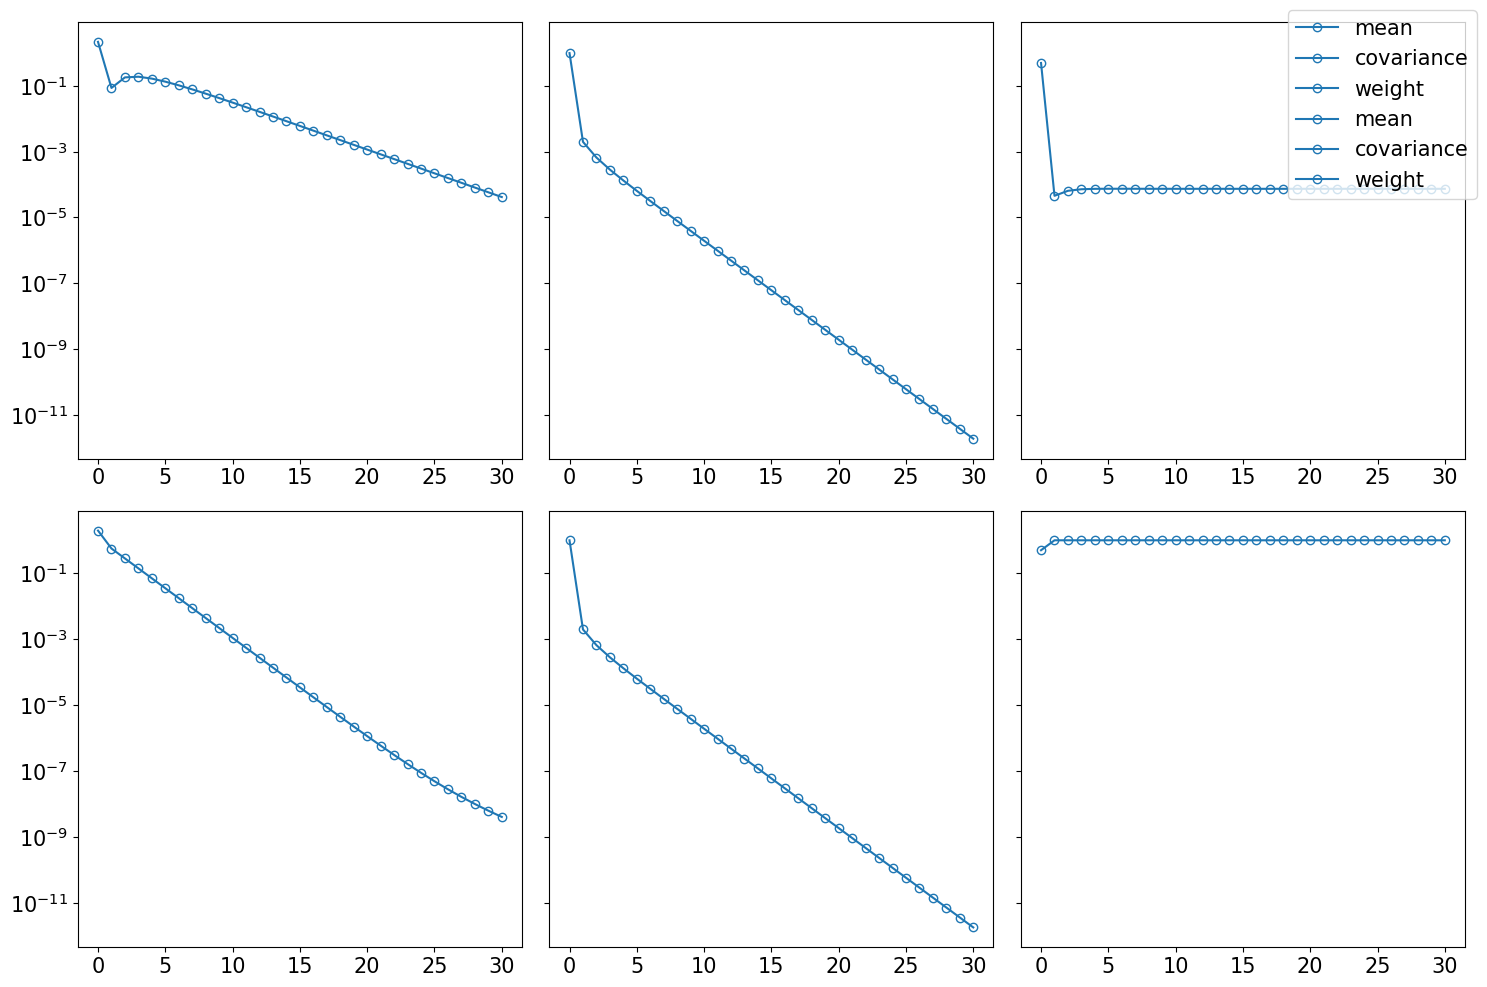

PyObject <matplotlib.legend.Legend object at 0x7fc34bdd58d0>

In [4]:
Random.seed!(123)
N_θ = 2
σ_0 = 1.0
prior_mean = zeros(FT, N_θ)
prior_cov = Array(Diagonal(fill(σ_0^2, N_θ)))
γ = 1.0
problem_type = "under-determined" #"over-determined"
    
θ_post, Σ_post, G, y, Σ_η = Two_Param_Linear_Test(problem_type, prior_mean, prior_cov)

N_y = length(y)

s_param = Setup_Param(G, N_θ, N_y)
s_param_aug = Setup_Param(G, N_θ, N_y+N_θ)


y_aug = [y ;prior_mean]
Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  prior_cov]


# compute posterior distribution by gmki
update_freq = 1
N_iter = 30
N_modes = 2



fig, ax = PyPlot.subplots(nrows=N_modes, ncols=3, sharex=false, sharey="row", figsize=(15,10))


θ0_w  = fill(1.0, N_modes)/N_modes
θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

for m = 1:N_modes
    θ0_mean[m, :]    .= rand(Normal(0, σ_0), N_θ)
    θθ0_cov[m, :, :] .= Array(Diagonal(fill(σ_0^2, N_θ)))
end
@info "Run GMKI with ", N_modes, " θ0_mean = ", θ0_mean
gmki_obj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1", mixture_power_sampling_method = "UKF-sampling")
gmki_errors    = zeros(FT, N_modes, N_iter+1, 3)


for iter = 1:N_iter+1
    for j = 1:N_modes
        gmki_errors[j, iter, 1] = norm(gmki_obj.θ_mean[iter][j,:] .- θ_post)/norm(θ_post)
        gmki_errors[j, iter, 2] = norm(gmki_obj.θθ_cov[iter][j,:,:] .- Σ_post)/norm(Σ_post)
        gmki_errors[j, iter, 3] = exp(gmki_obj.logθ_w[iter][j])
    end
end

ites = Array(0:N_iter)
for j = 1:N_modes
    ax[j, 1].semilogy(ites, gmki_errors[j, :, 1],   "-o", color = "C0", fillstyle="none", label="mean" )
    ax[j, 2].semilogy(ites, gmki_errors[j, :, 2],   "-o", color = "C0", fillstyle="none", label="covariance" )
    ax[j, 3].semilogy(ites, gmki_errors[j, :, 3],   "-o", color = "C0", fillstyle="none", label="weight" )

end

fig.tight_layout()
fig.legend()




# Continuous limit dynamics

Consider 1d Gaussian mixture with covariance 1

In [5]:
function gaussian(x, m, C)
    return 1/sqrt(2*pi*C) * exp(-0.5*(x - m)^2/C)
end

function gaussain_mixture(x, ws, ms, Cs)
    N = length(ws)
    ρ = 0
    for i = 1:N
        ρ += ws[i]*gaussian(x, ms[i], Cs[i])
    end
    return ρ
end

gaussain_mixture (generic function with 1 method)

In [6]:
# study ∫(θ-mₖ)Nₖlogρₜ  and ∫Nₖlogρₜ 

function loggm_intg(xx, ws, ms, Cs)
    N_x = length(xx)
    N_modes = length(ws)
    
    yy, ρ_g, ρ_gm, logρ_gm = zeros(N_x), zeros(N_modes, N_x), zeros(N_x), zeros(N_x)
    dm, dw = zeros(N_modes), zeros(N_modes)
    
    for i = 1:N_x
        ρ_gm[i] = gaussain_mixture(xx[i], ws, ms, Cs)
        logρ_gm[i] = log(ρ_gm[i])
        for k = 1:N_modes
            ρ_g[k, i] = gaussian(xx[i], ms[k], Cs[k])
        end
    end
        
    Q0, Q1 = zeros(N_modes, N_x), zeros(N_modes, N_x)
    Q0_approx, Q1_approx = zeros(N_modes, N_x), zeros(N_modes, N_x)
    
    for k = 1:N_modes
        for i = 1:N_x
            Q0[k, i] += ρ_g[k,i]*logρ_gm[i]
            Q1[k, i] += ρ_g[k,i]*logρ_gm[i]*(xx[i] - ms[k])
            Q0_approx[k, i] += ρ_g[k,i]*log(ws[k]*ρ_g[k,i])
            Q1_approx[k, i] += ρ_g[k,i]*log(ws[k]*ρ_g[k,i])*(xx[i] - ms[k])
    
        end
    end
    
    return sum(Q0, dims=2)*(xx[2] - xx[1]), sum(Q0_approx, dims=2)*(xx[2] - xx[1]), sum(Q1, dims=2)*(xx[2] - xx[1]), sum(Q1_approx, dims=2)*(xx[2] - xx[1])
end

loggm_intg (generic function with 1 method)

In [7]:
N_x = 2000
xx = Array(LinRange(-10, 10, N_x))

N_m = 1000
m2s = Array(LinRange(-2, 2, N_m))

Cs, ws = [1.0 ; 1.0], [0.5 ; 0.5]
N_modes = length(ws)
Q0s, Q1s = zeros(N_modes, N_m), zeros(N_modes, N_m)
Q0s_approx, Q1s_approx = zeros(N_modes, N_m), zeros(N_modes, N_m)

for i = 1:N_m
    ms = [-m2s[i] ; m2s[i]]
    Q0s[:, i], Q0s_approx[:, i], Q1s[:, i], Q1s_approx[:, i] = loggm_intg(xx, ws, ms, Cs)
end



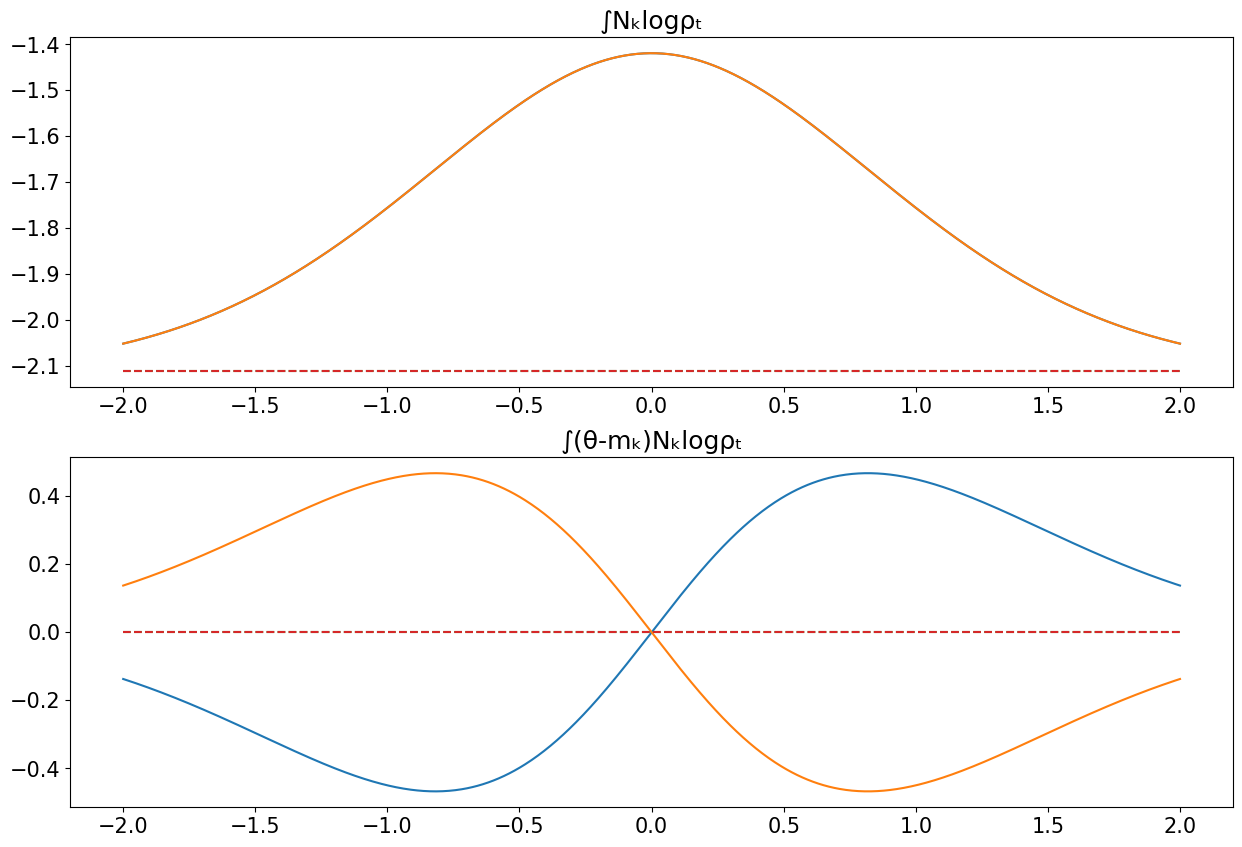

PyObject Text(0.5, 1.0, '∫(θ-mₖ)Nₖlogρₜ')

In [8]:
fig, ax = PyPlot.subplots(nrows=2, sharex=false, sharey="row", figsize=(15,10))
ax[1].plot(m2s, Q0s')
ax[1].plot(m2s, Q0s_approx', "--")
ax[1].set_title("∫Nₖlogρₜ")
ax[2].plot(m2s, Q1s')
ax[2].plot(m2s, Q1s_approx', "--")
ax[2].set_title("∫(θ-mₖ)Nₖlogρₜ")

In [9]:
# Study continuous time limit

function gmki_ctl_tendency(xx, ws, ms, Cs; m_post = 0)
    N_x = length(xx)
    N_modes = length(ws)
    
    yy, ρ_g, ρ_gm, logρ_gm = zeros(N_x), zeros(N_modes, N_x), zeros(N_x), zeros(N_x)
    dm, dw = zeros(N_modes), zeros(N_modes)
    
    for i = 1:N_x
        ρ_gm[i] = gaussain_mixture(xx[i], ws, ms, Cs)
        logρ_gm[i] = log(ρ_gm[i])
        for k = 1:N_modes
            ρ_g[k, i] = gaussian(xx[i], ms[k], Cs[k])
        end
    end
    
    
    for k = 1:N_modes
        for i = 1:N_x
            yy[i] = (xx[i] - ms[k])*ρ_g[k,i]*logρ_gm[i]
        end
        dm[k] = -sum(yy)*(xx[2]-xx[1]) + m_post - ms[k]
        
        for i = 1:N_x
            yy[i] = (ρ_g[k,i] - ρ_gm[i])*logρ_gm[i]
        end
        dw[k] = -ws[k]*(sum(yy)*(xx[2]-xx[1]) + 0.5*(ms[k] - m_post)^2 - 0.5*(ws' * (ms .- m_post).^2))
    end
    
    return dm, dw
end



function gmki_ctl(xx, ws0, ms0, Cs0, dt, N_t; m_post = 0)
    N_modes = length(ws0)
    ms_traj, ws_traj = zeros(N_t,N_modes), zeros(N_t,N_modes)
    ms, ws, Cs = copy(ms0), copy(ws0), copy(Cs0)
    
    for i = 1:N_t
        dm, dw = gmki_ctl_tendency(xx, ws, ms, Cs)
        ms, ws = ms + dt*dm, ws + dt*dw
        
        ms_traj[i, :], ws_traj[i, :] = ms, ws
    end
    
    return ms_traj, ws_traj
end




gmki_ctl (generic function with 1 method)

In [10]:
N_x = 2000
xx = Array(LinRange(-5, 5, N_x))
# Cs = [1.0 ; 1.0; 1.0]
# ws, ms = [0.2 ; 0.5; 0.3], [-0.3 ; 0.3; 0.2]

Cs = [1.0 ; 1.0; 1.0]
ws, ms = [0.2 ; 0.5; 0.3], [-0.2 ; 0.2; 0.5]


dm, dw = gmki_ctl_tendency(xx, ws, ms, Cs)

([-0.1868466847212839, -0.20964496986619593, -0.22626676926976907], [0.016615775650991368, 0.001876713287063382, -0.018492488938054726])

In [13]:
dt, N_t = 1e-1, 1000
ts_traj = Array(dt*(1:N_t))
ms_traj, ws_traj = gmki_ctl(xx, ws, ms, Cs, dt, N_t);

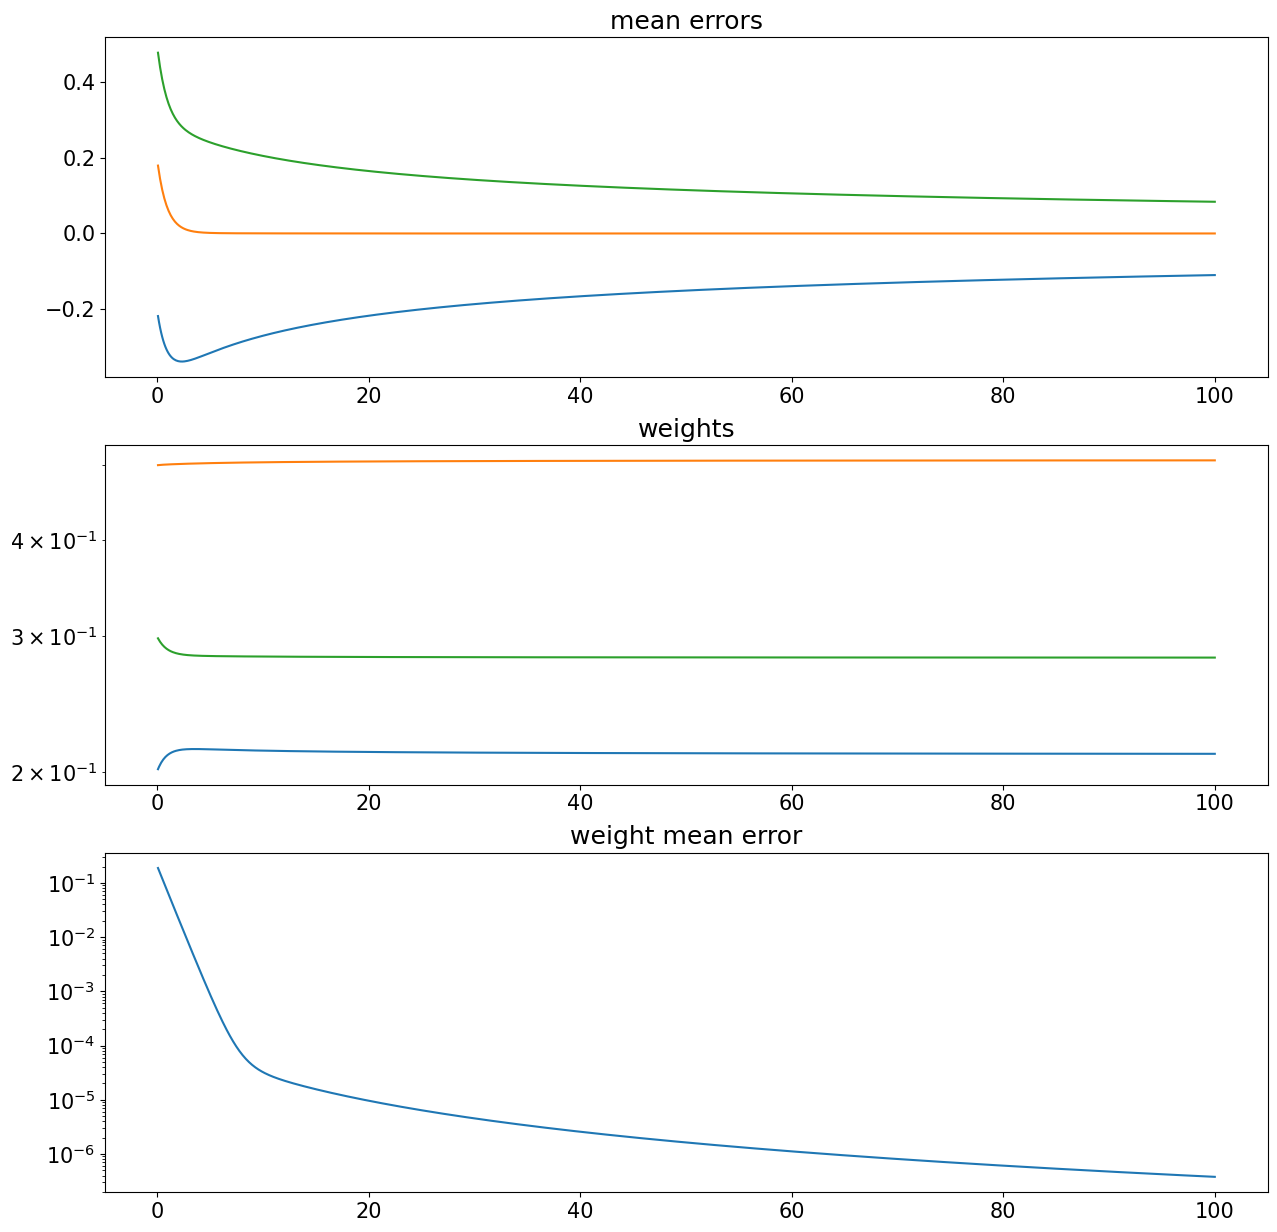

PyObject Text(0.5, 1.0, 'weight mean error')

In [14]:
fig, ax = PyPlot.subplots(nrows=3, sharex=false, sharey="row", figsize=(15,15))
ax[1].plot(ts_traj,  ms_traj)
ax[1].set_title("mean errors")
ax[2].semilogy(ts_traj, ws_traj)
ax[2].set_title("weights")
wms_traj = sum(ws_traj .* ms_traj, dims=2)
ax[3].semilogy(ts_traj, abs.(wms_traj .- 0.0))
ax[3].set_title("weight mean error")

In [29]:
ms_traj

100000×3 Matrix{Float64}:
 -0.218685     0.179036    0.477373
 -0.235187     0.160287    0.456987
 -0.249743     0.143518    0.438604
 -0.262562     0.128519    0.422015
 -0.273831     0.115102    0.407031
 -0.283718     0.1031      0.393484
 -0.292371     0.0923611   0.381224
 -0.299926     0.0827529   0.370116
 -0.3065       0.0741552   0.36004
 -0.312199     0.0664612   0.350889
 -0.31712      0.0595751   0.342567
 -0.321347     0.0534117   0.334988
 -0.324956     0.0478945   0.328075
  ⋮                        
 -0.00286866  -1.16943e-5  0.00217023
 -0.0028686   -1.1694e-5   0.00217018
 -0.00286854  -1.16938e-5  0.00217014
 -0.00286847  -1.16935e-5  0.00217009
 -0.00286841  -1.16933e-5  0.00217004
 -0.00286835  -1.1693e-5   0.00216999
 -0.00286829  -1.16928e-5  0.00216995
 -0.00286823  -1.16925e-5  0.0021699
 -0.00286817  -1.16923e-5  0.00216985
 -0.0028681   -1.1692e-5   0.00216981
 -0.00286804  -1.16918e-5  0.00216976
 -0.00286798  -1.16915e-5  0.00216971

In [38]:
@info gmki_ctl_tendency(xx, ws_traj[end, :], ms_traj[end, :], Cs)

┌ Info: ([1.1118521024165717e-5, -1.1118521024224698e-5], [-4.092863201132779e-18, -3.333921680392926e-18])
└ @ Main In[38]:1


In [97]:
7/sqrt(2)

4.949747468305833

# Plot Gaussian/Gaussian mixture

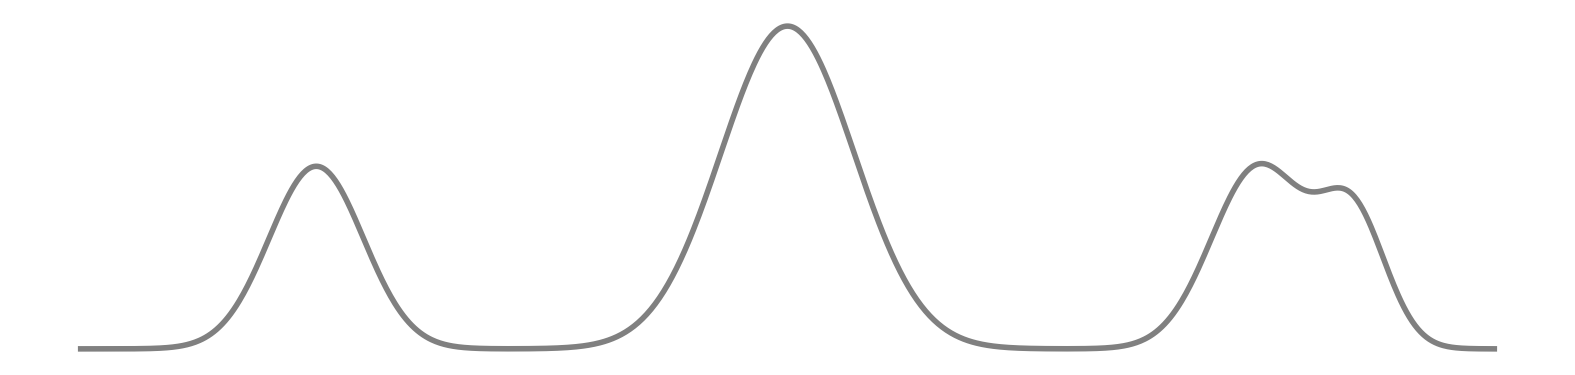

In [19]:
Nx = 1000
xx_ref = Array(LinRange(-7.5, 7.5, Nx))
yy_ref = copy(xx_ref)

ws = [0.2; 0.5; 0.2; 0.1]
ms = [-5; 0; 5.0; 6.0]
Cs = [1.0; 2.0; 1.0; 0.5]/4
for i = 1:Nx
    yy_ref[i] = gaussain_mixture(xx_ref[i], ws, ms, Cs)
end
figure(figsize=(16, 4))
fig = plot(xx_ref, yy_ref, color="grey", linewidth=4.0)
axis("off")
tight_layout()
savefig("Gaussian_mixture.pdf")